In [8]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
import pprint
from sklearn.utils import shuffle
p = pprint.PrettyPrinter(indent=4, width=30)
pretty = p.pprint

print('libraries loaded')

libraries loaded


In [13]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # Note: there's a leading space for each column name except for the first one
        # let's strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        df.drop(columns=['Source IP', 'Destination IP'], inplace=True)
        # drop missing values/NaN etc.
        df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]=='NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        # convert  Flow Bytes/s object & Flow Packets/s object into float type
        df['Flow Bytes/s'] = df['Flow Bytes/s'].astype('float64')
        df['Flow Packets/s'] = df['Flow Packets/s'].astype('float64')
        print(df.tail())
        df.to_pickle(pickleDump)
    
    return df

In [10]:
dataPath = '../CSV/Scenario-A'
data: list = [
    'merged_5s.csv',
    'SelectedFeatures-10s-TOR-NonTor.csv',
    'SelectedFeatures-15s-TOR-NonTor.csv',
    'TimeBasedFeatures-15s-TOR-NonTOR.csv',
    'TimeBasedFeatures-15s-TOR-NonTOR-15.csv',
    'TimeBasedFeatures-15s-TOR-NonTOR-85.csv',
    'TimeBasedFeatures-30s-TORNonTor.csv',
    'TimeBasedFeatures-30s-TORNonTOR-15.csv',
    'TimeBasedFeatures-30s-TORNonTOR-85.csv',
    'TimeBasedFeatures-60s-TOR-NonTor.csv',
    'TimeBasedFeatures-60s-TOR-NonTOR-15.csv',
    'TimeBasedFeatures-60s-TOR-NonTOR-85.csv',
    'TimeBasedFeatures-120s-TOR-NonTor.csv',
    'TimeBasedFeatures-120s-TOR-NonTOR-15.csv',
    'TimeBasedFeatures-120s-TOR-NonTOR-85.csv'
]
    
def get_file_path(file):
    return os.path.join(dataPath, file)

csvFiles: list = list(map(get_file_path, data))

print(f'Running: {len(csvFiles)} experiments\n')
pretty(csvFiles)
csvFile = os.path.join(dataPath, 'merged_5s.csv')

Running: 15 experiments

[   '../CSV/Scenario-A/merged_5s.csv',
    '../CSV/Scenario-A/SelectedFeatures-10s-TOR-NonTor.csv',
    '../CSV/Scenario-A/SelectedFeatures-15s-TOR-NonTor.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-15.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-30s-TORNonTor.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-30s-TORNonTOR-15.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-30s-TORNonTOR-85.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTor.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-15.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTor.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-15.csv',
    '../CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.csv']


In [12]:
df = loadData(csvFile)

In [14]:
# check datatypes of each features
df.dtypes

Source Port           int64
Destination Port      int64
Protocol              int64
Flow Duration         int64
Flow Bytes/s        float64
Flow Packets/s      float64
Flow IAT Mean       float64
Flow IAT Std        float64
Flow IAT Max          int64
Flow IAT Min          int64
Fwd IAT Mean        float64
Fwd IAT Std         float64
Fwd IAT Max           int64
Fwd IAT Min           int64
Bwd IAT Mean        float64
Bwd IAT Std         float64
Bwd IAT Max           int64
Bwd IAT Min           int64
Active Mean           int64
Active Std            int64
Active Max            int64
Active Min            int64
Idle Mean             int64
Idle Std              int64
Idle Max              int64
Idle Min              int64
label                object
dtype: object

In [15]:
# total Tor samples
print('total TOR:', len(df[df['label'] == 'TOR'].index))
print('total nonTOR: ', len(df[df['label'] == 'nonTOR'].index))

total TOR: 14508
total nonTOR:  69684


In [16]:
dep_var = 'label'
cat_names = ['Source Port', 'Destination Port', 'Protocol']
cont_names = list(set(df.columns) - set(cat_names) - set([dep_var]))

In [17]:
cont_names

['Active Mean',
 'Fwd IAT Mean',
 'Bwd IAT Mean',
 'Bwd IAT Min',
 'Flow Packets/s',
 'Active Std',
 'Fwd IAT Min',
 'Idle Min',
 'Idle Max',
 'Idle Mean',
 'Idle Std',
 'Flow Bytes/s',
 'Bwd IAT Std',
 'Active Min',
 'Flow IAT Std',
 'Fwd IAT Std',
 'Bwd IAT Max',
 'Flow Duration',
 'Flow IAT Max',
 'Fwd IAT Max',
 'Flow IAT Mean',
 'Active Max',
 'Flow IAT Min']

In [18]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.172338,01:19
1,nan,nan,0.172338,01:24


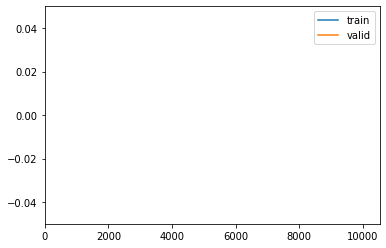

In [ ]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[50, 20], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #
    model.save('{}.model'.format(os.path.basename(csvFile)))

In [ ]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

In [ ]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix()